In [19]:
import pandas as pd
import pyarrow as pa
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import umap
from sklearn.preprocessing import StandardScaler

/home/kradja/miniforge3/envs/prefect3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
data = Path("./").resolve().parent / "data"
concat_breast = data / "concat_breast_df.pkl"
concat_lung= data / "concat_lung_df.pkl"
if concat_breast.exists():
    bdf = pd.read_pickle(concat_breast)
if concat_lung.exists():
    ldf = pd.read_pickle(concat_lung)

In [18]:
bdf_desc = bdf.describe()
ldf_desc = ldf.describe()
print(bdf_desc.columns)

Index(['Centroid X µm', 'Centroid Y µm', 'Nucleus: Area', 'Nucleus: Perimeter',
       'Nucleus: Circularity', 'Nucleus: Max caliper', 'Nucleus: Min caliper',
       'Nucleus: Eccentricity', 'Nucleus: Hematoxylin OD mean',
       'Nucleus: Hematoxylin OD sum', 'Nucleus: Hematoxylin OD std dev',
       'Nucleus: Hematoxylin OD max', 'Nucleus: Hematoxylin OD min',
       'Nucleus: Hematoxylin OD range', 'Nucleus: Eosin OD mean',
       'Nucleus: Eosin OD sum', 'Nucleus: Eosin OD std dev',
       'Nucleus: Eosin OD max', 'Nucleus: Eosin OD min',
       'Nucleus: Eosin OD range'],
      dtype='object')


In [12]:
filt_bdf = bdf[bdf["Nucleus: Area"] >= 38.45]
filt_bdf = filt_bdf[filt_bdf["Nucleus: Area"] <= 78.5]
filt_bdf = filt_bdf[filt_bdf["Nucleus: Hematoxylin OD mean"] >= 0.75]
filt_bdf.to_csv("breast_filtered_tils.csv")
# Lung
filt_ldf = ldf[ldf["Nucleus: Area"] >= 38.45]
filt_ldf = filt_ldf[filt_ldf["Nucleus: Area"] <= 78.5]
filt_ldf = filt_ldf[filt_ldf["Nucleus: Hematoxylin OD mean"] >= 0.75]
filt_ldf.to_csv("lung_filtered_tils.csv")

In [13]:
def col_df(colname: str,bdf: pd.DataFrame, ldf: pd.DataFrame) -> pd.DataFrame:
    tmpb = bdf[colname].reset_index(drop=True).rename("Breast")
    tmpl = ldf[colname].reset_index(drop=True).rename("Lung")
    return pd.concat([tmpb, tmpl],axis=1)

In [14]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

9.638434642398304e-79


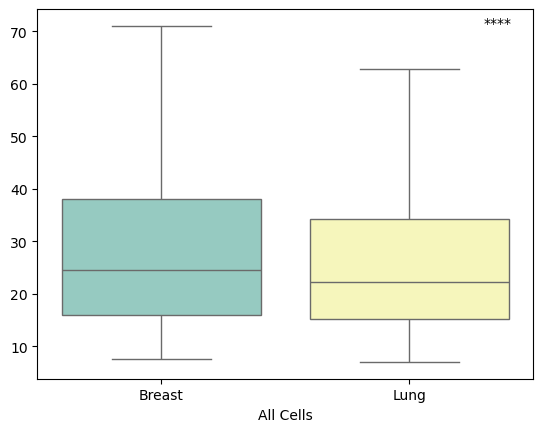

In [15]:
nucl_area = col_df("Nucleus: Area", bdf,ldf)
ttest_res = ttest_ind(nucl_area["Breast"].dropna(), nucl_area["Lung"].dropna())
print(ttest_res.pvalue)
plt.figure()
sns.boxplot(data=nucl_area, showfliers=False, palette="Set3")
if ttest_res.pvalue < 0.05:
    plt.text(0.9,0.95,convert_pvalue_to_asterisks(ttest_res.pvalue), transform=plt.gca().transAxes)
plt.xlabel("All Cells")
plt.show()

1.3927870211552005e-05


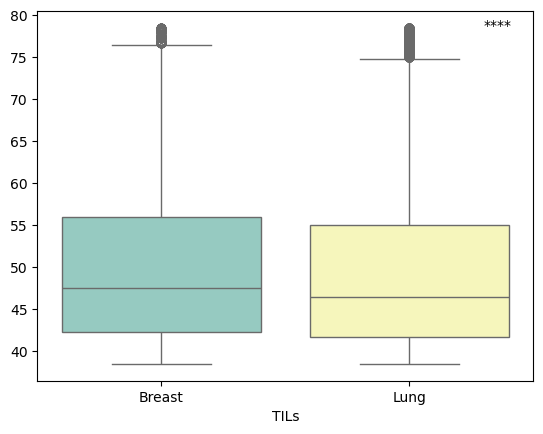

In [16]:
nucl_area_til = col_df("Nucleus: Area", filt_bdf,filt_ldf)
ttest_res = ttest_ind(nucl_area_til["Breast"].dropna(), nucl_area_til["Lung"].dropna())
print(ttest_res.pvalue)
plt.figure()
sns.boxplot(data=nucl_area_til, showfliers=True, palette="Set3")
if ttest_res.pvalue < 0.05:
    plt.text(0.9,0.95,convert_pvalue_to_asterisks(ttest_res.pvalue), transform=plt.gca().transAxes)
plt.xlabel("TILs")
plt.show()

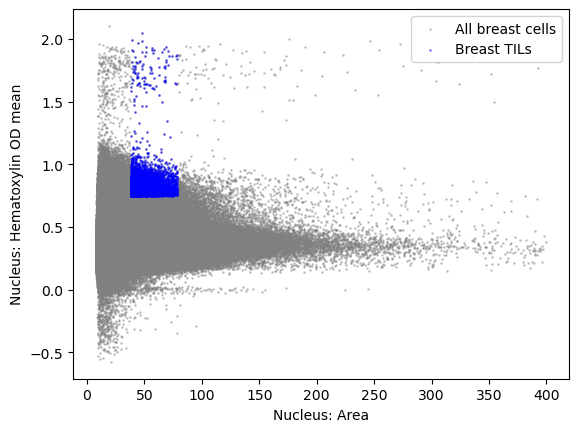

In [19]:
plt.figure()
plt.scatter(bdf["Nucleus: Area"], bdf["Nucleus: Hematoxylin OD mean"], color="grey",alpha=0.4,s=0.8)
plt.scatter(filt_bdf["Nucleus: Area"], filt_bdf["Nucleus: Hematoxylin OD mean"], color="blue",alpha=0.4,s=0.9)
plt.ylabel("Nucleus: Hematoxylin OD mean")
plt.xlabel("Nucleus: Area")
plt.legend(["All breast cells", "Breast TILs"], loc="upper right")
plt.show()

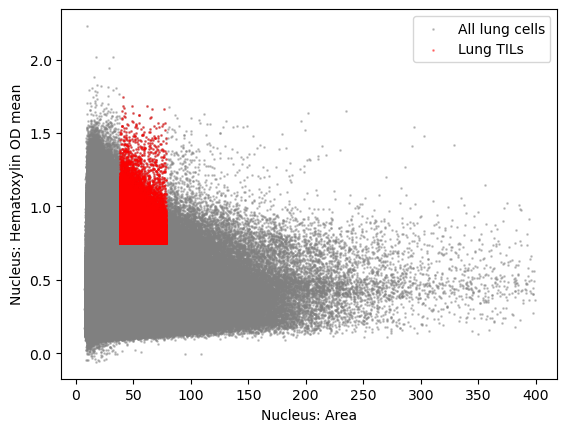

In [18]:
plt.figure()
plt.scatter(ldf["Nucleus: Area"], ldf["Nucleus: Hematoxylin OD mean"],color="grey",alpha=0.4,s=0.9)
plt.scatter(filt_ldf["Nucleus: Area"], filt_ldf["Nucleus: Hematoxylin OD mean"], color="red",alpha=0.4,s=0.9)
plt.ylabel("Nucleus: Hematoxylin OD mean")
plt.xlabel("Nucleus: Area")
plt.legend(["All lung cells", "Lung TILs"])
plt.show()

In [64]:
print(len(filt_bdf) / len(bdf))
print(len(filt_ldf) / len(ldf))


0.0026963509229280445
0.018435995691166107


In [21]:
filt_bdf["Tissue"] = "Breast"
filt_ldf["Tissue"] = "Lung"
concat_tils = pd.concat([filt_bdf, filt_ldf], axis=0)
cols_list = list(concat_tils.columns)

In [26]:
concat_tils[cols_list[7:-1]].head()

,Centroid X µm,Centroid Y µm,Nucleus: Area,Nucleus: Perimeter,Nucleus: Circularity,Nucleus: Max caliper,Nucleus: Min caliper,Nucleus: Eccentricity,Nucleus: Hematoxylin OD mean,Nucleus: Hematoxylin OD sum,Nucleus: Hematoxylin OD std dev,Nucleus: Hematoxylin OD max,Nucleus: Hematoxylin OD min,Nucleus: Hematoxylin OD range,Nucleus: Eosin OD mean,Nucleus: Eosin OD sum,Nucleus: Eosin OD std dev,Nucleus: Eosin OD max,Nucleus: Eosin OD min,Nucleus: Eosin OD range
69,7007.0,2111.0,38.75,28.5197,0.5987,9.764,6.3683,0.7935,0.7912,127.3775,0.1224,1.0795,0.3505,0.7289,0.5155,82.9917,0.1577,0.8367,-0.067,0.9037
234,6926.4,2155.7,42.75,29.5901,0.6136,10.435,6.7555,0.7616,0.795,136.7456,0.1682,1.2631,0.3857,0.8774,0.4759,81.8607,0.1984,0.9115,-0.2009,1.1124
334,7011.0,2181.8,42.75,27.4674,0.7121,10.3832,5.82,0.8594,0.8547,148.7129,0.1557,1.3234,0.3688,0.9546,0.5486,95.4627,0.2083,1.0336,-0.1952,1.2288
351,6898.1,2186.0,44.75,28.2895,0.7027,11.854,5.6924,0.907,0.8418,153.2039,0.1548,1.2688,0.3933,0.8754,0.5331,97.0282,0.1648,0.8517,-0.0364,0.8881
364,6985.9,2188.4,40.5,32.3913,0.4851,9.304,8.2968,0.5122,0.7741,126.9508,0.1724,1.1637,0.208,0.9557,0.4819,79.028,0.1749,0.8531,-0.1026,0.9557


In [33]:
len(scaled_tils)
scaled_tils.shape

(51615, 20)

In [28]:
scaled_tils= StandardScaler().fit_transform(concat_tils[cols_list[7:-1]])
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_tils)
embedding.shape

(51615, 2)

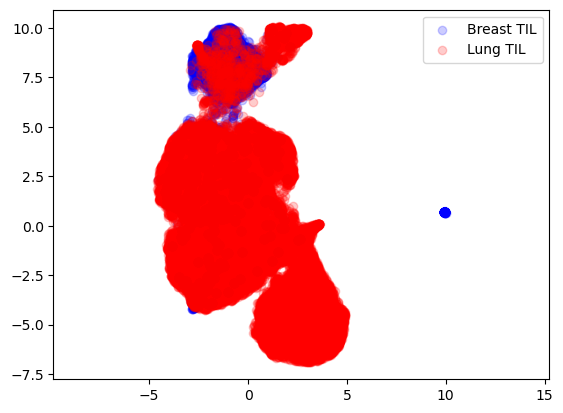

In [36]:
breast_embedding = embedding[concat_tils["Tissue"] == "Breast"]
lung_embedding = embedding[concat_tils["Tissue"] == "Lung"]
plt.scatter(breast_embedding[:,0], breast_embedding[:,1], color="blue", alpha=0.2)
plt.scatter(lung_embedding[:,0], lung_embedding[:,1], color="red", alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of TILs', fontsize=16);
plt.legend(["Breast TIL", "Lung TIL"])
plt.show()

In [23]:

ranksums(filt_bdf["Nucleus: Area"], filt_ldf["Nucleus: Area"])

RanksumsResult(statistic=5.352904888841326, pvalue=8.655334935188115e-08)